In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
MEMORY = 1*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-22 17:24:37.651571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 17:24:37.844091: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-22 17:24:38.551801: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [384]:
def subcircuit_1(y, t, OC14, mu_F, mu_E, V_F, V_E, K, K_EF, K_EE, nvd=2, nfe=2):
    F, E = y
    dFdt = mu_F*(1 + V_F/(1 + (K/OC14)**nvd) - F)
    dEdt = mu_E*(1 + V_E/(1 + (F/K_EF)**nfe)/(1 + (K_EE/E)**nfe) - E)
    return [dFdt, dEdt]

In [462]:
t = np.linspace(0, 10, 1000)
y0 = (0,0)
(OC14, mu_F, mu_E, V_F, V_E, K, K_EF, K_EE) = (0.1, 1, 1, 1, 1, 1, 1, 1)
sol = odeint(subcircuit_1, y0, t, args=(OC14, mu_F, mu_E, V_F, V_E, K, K_EF, K_EE))

In [463]:
(sol[-1, 0]-sol[-2, 0])/10

4.612821395966193e-08

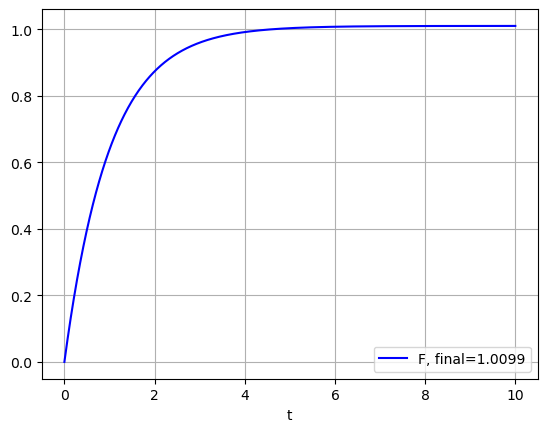

In [464]:
plt.plot(t, sol[:, 0], 'b', label=f"F, final={sol[-1, 0]:.4f}")
#plt.plot(t, sol[:, 1], 'g', label=f"E, final={sol[-1, 1]:.4f}")
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [361]:
class NN_Scaled2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)

    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        #H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        H = inputs
        for W, a, b in zip(self.weights, self.scales, self.biases):
            outputs = tf.matmul(H, W)
            outputs = a * outputs + b
            #H = tf.tanh(outputs)
            H = tf.nn.sigmoid(outputs)

        return outputs


In [472]:
lb = tf.constant([t[0]], dtype=tf.float32)
ub =  tf.constant([t[-1]], dtype=tf.float32)
pinn = NN_Scaled2([1, 1024, 1024, 1], lb, ub, tf.float32)

In [473]:
optimizer=keras.optimizers.Adam(learning_rate=1e-3)

def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)



print("="*20)
print("OC14: ", OC14)
print("mu_F: ", mu_F)
print("mu_E: ", mu_E)
print("V_F: ", V_F) 
print("V_E: ", V_E)
print("K: ", K) 
print("K_EF: ", K_EF) 
print("K_EE: ", K_EE)

def create_tf_var(name, value, no_clip=False):
    if no_clip:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name)
    else:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

OC14_tf = create_tf_var("OC14", OC14)
mu_F_tf = create_tf_var("mu_F", mu_F)
mu_E_tf = create_tf_var("mu_E", mu_F)
V_F_tf = create_tf_var("V_F", V_F)
V_E_tf = create_tf_var("V_E", V_E)
K_tf = create_tf_var("K", K)
K_EF_tf = create_tf_var("K_EF", K_EF)
K_EE_tf = create_tf_var("K_EE", K_EE)

nvd = 2
nfe = 2

@tf.function
def train_step(elements):
    with tf.GradientTape(persistent=True) as tape: 
        ts = tf.squeeze(elements[0])[:, tf.newaxis]
        t_inf = ts[-1:]
        #print(ts.shape)
        F_t_inf = elements[1]
        E_t_inf = elements[2]
        F_t_zero = elements[3]
        E_t_zero = elements[4]
        
        tape.watch(ts)
        tape.watch(t_inf)
        #tape.watch(F_t_inf)
        #tape.watch(E_t_inf)
        trainables = pinn.trainable_variables 
        
        outputs = pinn.net(ts)
        F = tf.squeeze(outputs[:, 0])
        #E = tf.squeeze(outputs[:, 1])

        dF_dt = tape.gradient(F, ts)
        #dE_dt = tape.gradient(E, ts)        
        
        
        res_F = mu_F_tf*(1. + V_F_tf/(1. + (K_tf/OC14_tf)**nvd) - F) - dF_dt
        #res_E = mu_E_tf*(1. + V_E_tf/((1. + (F/K_EF_tf)**nfe)*(1. + (K_EE_tf/E)**nfe)) - E) - dE_dt
        l2_res_F = tf.reduce_sum(res_F**2)
        #l2_res_E = tf.reduce_sum(res_E**2)
        
        estimated_t_inf = pinn.net(t_inf)        
        F_estimated_t_inf = estimated_t_inf[:, 0]
        dF_dt_t_inf = tape.gradient(estimated_t_inf, t_inf)        
        res_F_t_inf = mu_F_tf*(1. + V_F_tf/(1. + (K_tf/OC14_tf)**nvd) - F_estimated_t_inf)
#         E_estimated_t_inf = estimated_t_inf[:, 1]        
    
        
        l2_F_t_inf = tf.reduce_sum( (F_estimated_t_inf - F_t_inf)**2)/F.shape[0]
        l2_dF_dt = tf.reduce_sum( (dF_dt_t_inf)**2)/F.shape[0]
        l2_res_F_t_inf = tf.reduce_sum( (res_F_t_inf)**2)/F.shape[0]        
#         l2_E = tf.reduce_sum( (E_estimated_t_inf - E_t_inf)**2)
        
        
        estimated_t_zero = pinn.net(ts[0:1])
        F_estimated_t_zero = estimated_t_zero[:, 0]
        #E_estimated_t_zero = estimated_t_zero[:, 1]
        
        l2_F_0 = tf.reduce_sum( (F_estimated_t_zero - F_t_zero)**2)/F.shape[0]
        #l2_E_0 = tf.reduce_sum( (E_estimated_t_zero - E_t_zero)**2)
        

        

        #l2 = 10*l2_res_F + 10*l2_res_E + l2_F + l2_E+ 1000*l2_F_0 + 1000*l2_E_0
        l2 = l2_res_F +  1000*l2_F_0 + 1000*l2_F_t_inf + 10000*l2_dF_dt + l2_res_F_t_inf

    grads = tape.gradient(l2, trainables)
    #print(trainables)
    #print(grads)
    optimizer.apply_gradients(zip(grads, trainables))
    #print(trainables)
    #return (l2_res_F,l2_res_E, l2_F, l2_E, l2_F_0, l2_E_0)
    return (l2_res_F, l2_F_0, l2_F_t_inf, l2_dF_dt, l2_res_F_t_inf )


OC14:  0.1
mu_F:  1
mu_E:  1
V_F:  1
V_E:  1
K:  1
K_EF:  1
K_EE:  1


In [474]:
#ts = np.linspace(0, 10, 1000)
def gen_series_1():
    for it in t:
        yield it, sol[-1, 0], sol[-1, 1] , 0.0, 0.0
        
ds = tf.data.Dataset.from_generator(gen_series_1,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((),(),(),(),()))

In [475]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses):.8f}"
            f" Res F: {losses[0]:.8f}, F(T_0): {losses[1]:.8f}\n"
            f" F(T_inf): {losses[2]:.8f}, dFdt(T_inf): {losses[3]:.8f}\n"
            f" RHS F: {losses[4]:.8f}"
            #f" Res F: {losses[0]:.8f}, Res E: {losses[1]:.8f}\n"
            #f" F(T_inf): {losses[2]:.8f}, E(T_inf): {losses[3]:.8f}"
            #f" F(T_0): {losses[4]:.8f}, E(T_0): {losses[5]:.8f}"
           ) 


Start of epoch 0


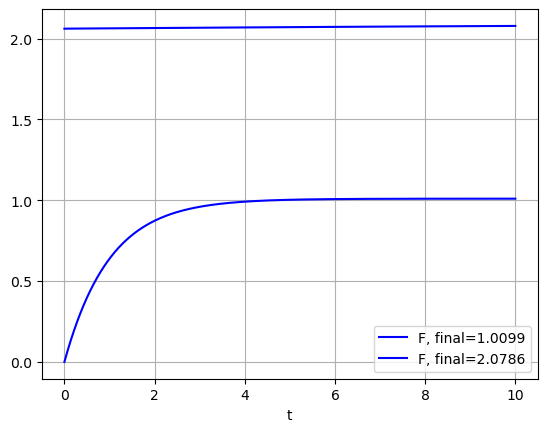

at epoch 0,  total loss: 4182826.89793672 Res F: 4182784.01953125, F(T_0): 26.07970089
 F(T_inf): 16.76517490, dFdt(T_inf): 0.00000002
 RHS F: 0.03352967
Time taken: 3.40s

Start of epoch 200
at epoch 200,  total loss: 1612.44204571 Res F: 1610.70999146, F(T_0): 1.72841728
 F(T_inf): 0.00362910, dFdt(T_inf): 0.00000061
 RHS F: 0.00000726
Time taken: 7.39s

Start of epoch 400
at epoch 400,  total loss: 1629.50297008 Res F: 1627.75305176, F(T_0): 1.74594444
 F(T_inf): 0.00396546, dFdt(T_inf): 0.00000048
 RHS F: 0.00000794
Time taken: 7.54s

Start of epoch 600
at epoch 600,  total loss: 1653.62227751 Res F: 1651.85467148, F(T_0): 1.76327753
 F(T_inf): 0.00431949, dFdt(T_inf): 0.00000036
 RHS F: 0.00000865
Time taken: 7.44s

Start of epoch 800
at epoch 800,  total loss: 1686.67989883 Res F: 1684.89496231, F(T_0): 1.78023154
 F(T_inf): 0.00469533, dFdt(T_inf): 0.00000026
 RHS F: 0.00000940
Time taken: 7.49s

Start of epoch 1000


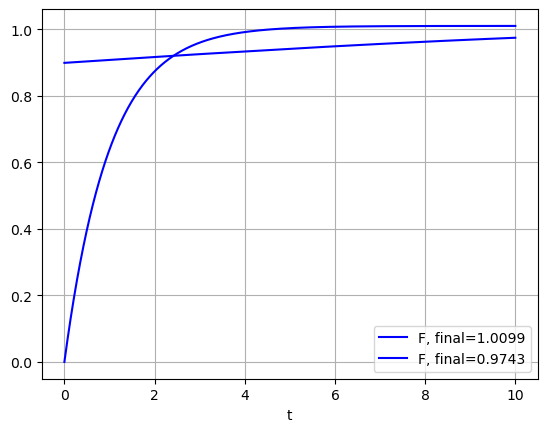

at epoch 1000,  total loss: 1717.91695180 Res F: 1716.11690521, F(T_0): 1.79502910
 F(T_inf): 0.00500728, dFdt(T_inf): 0.00000018
 RHS F: 0.00001002
Time taken: 7.60s

Start of epoch 1200
at epoch 1200,  total loss: 1753.12097572 Res F: 1751.31233406, F(T_0): 1.80347019
 F(T_inf): 0.00516102, dFdt(T_inf): 0.00000012
 RHS F: 0.00001033
Time taken: 7.43s

Start of epoch 1400
at epoch 1400,  total loss: 1744.76652625 Res F: 1742.96936035, F(T_0): 1.79258358
 F(T_inf): 0.00457305, dFdt(T_inf): 0.00000011
 RHS F: 0.00000916
Time taken: 7.53s

Start of epoch 1600
at epoch 1600,  total loss: 1775.57730994 Res F: 1773.86003876, F(T_0): 1.71441776
 F(T_inf): 0.00284753, dFdt(T_inf): 0.00000020
 RHS F: 0.00000571
Time taken: 7.52s

Start of epoch 1800
at epoch 1800,  total loss: 2160.87545858 Res F: 2159.27297020, F(T_0): 1.59994018
 F(T_inf): 0.00254297, dFdt(T_inf): 0.00000014
 RHS F: 0.00000510
Time taken: 7.46s

Start of epoch 2000


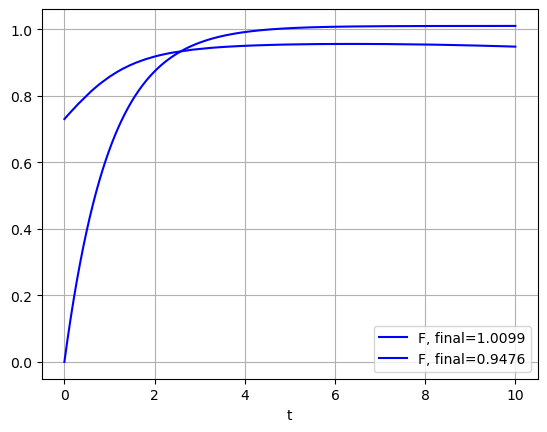

at epoch 2000,  total loss: 2397.30046058 Res F: 2395.75130939, F(T_0): 1.54591900
 F(T_inf): 0.00322566, dFdt(T_inf): 0.00000005
 RHS F: 0.00000646
Time taken: 7.64s

Start of epoch 2200
at epoch 2200,  total loss: 2496.62652710 Res F: 2495.09703445, F(T_0): 1.52569783
 F(T_inf): 0.00378721, dFdt(T_inf): 0.00000002
 RHS F: 0.00000759
Time taken: 7.51s

Start of epoch 2400
at epoch 2400,  total loss: 2515.36137925 Res F: 2513.84273529, F(T_0): 1.51468223
 F(T_inf): 0.00395378, dFdt(T_inf): 0.00000003
 RHS F: 0.00000792
Time taken: 7.51s

Start of epoch 2600
at epoch 2600,  total loss: 2517.53400572 Res F: 2516.02354622, F(T_0): 1.50650305
 F(T_inf): 0.00394850, dFdt(T_inf): 0.00000005
 RHS F: 0.00000791
Time taken: 7.45s

Start of epoch 2800
at epoch 2800,  total loss: 2512.19857944 Res F: 2510.69530869, F(T_0): 1.49940431
 F(T_inf): 0.00385864, dFdt(T_inf): 0.00000008
 RHS F: 0.00000773
Time taken: 7.44s

Start of epoch 3000


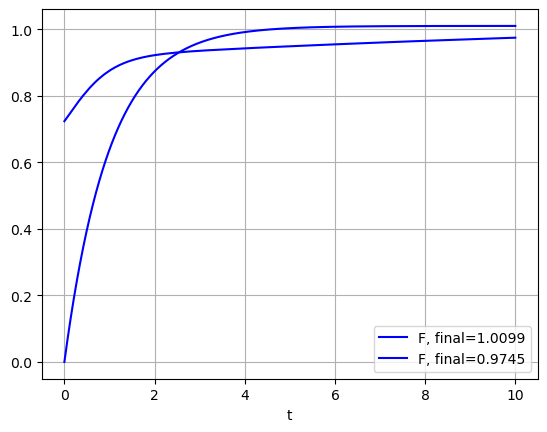

at epoch 3000,  total loss: 2507.23879285 Res F: 2505.74189186, F(T_0): 1.49313968
 F(T_inf): 0.00375368, dFdt(T_inf): 0.00000011
 RHS F: 0.00000752
Time taken: 7.65s

Start of epoch 3200
at epoch 3200,  total loss: 2505.27295811 Res F: 2503.78101921, F(T_0): 1.48827237
 F(T_inf): 0.00365907, dFdt(T_inf): 0.00000014
 RHS F: 0.00000733
Time taken: 7.50s

Start of epoch 3400
at epoch 3400,  total loss: 2505.66243645 Res F: 2504.17468262, F(T_0): 1.48417425
 F(T_inf): 0.00357227, dFdt(T_inf): 0.00000016
 RHS F: 0.00000716
Time taken: 7.44s

Start of epoch 3600
at epoch 3600,  total loss: 2504.42757155 Res F: 2502.94338608, F(T_0): 1.48069513
 F(T_inf): 0.00348318, dFdt(T_inf): 0.00000018
 RHS F: 0.00000698
Time taken: 7.47s

Start of epoch 3800
at epoch 3800,  total loss: 2506.62409759 Res F: 2505.14315033, F(T_0): 1.47754472
 F(T_inf): 0.00339554, dFdt(T_inf): 0.00000020
 RHS F: 0.00000680
Time taken: 7.41s

Start of epoch 4000


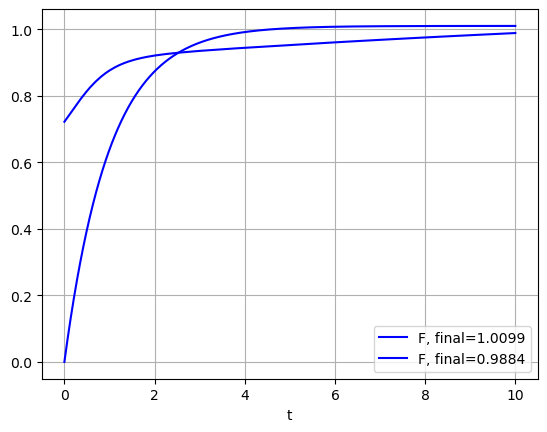

at epoch 4000,  total loss: 2509.64428252 Res F: 2508.16621017, F(T_0): 1.47476405
 F(T_inf): 0.00330147, dFdt(T_inf): 0.00000021
 RHS F: 0.00000661
Time taken: 7.52s

Start of epoch 4200
at epoch 4200,  total loss: 2514.29467254 Res F: 2512.81949234, F(T_0): 1.47197366
 F(T_inf): 0.00319992, dFdt(T_inf): 0.00000022
 RHS F: 0.00000641
Time taken: 7.50s

Start of epoch 4400
at epoch 4400,  total loss: 2518.62459163 Res F: 2517.15214920, F(T_0): 1.46933955
 F(T_inf): 0.00309646, dFdt(T_inf): 0.00000022
 RHS F: 0.00000620
Time taken: 7.49s

Start of epoch 4600
at epoch 4600,  total loss: 2522.65393864 Res F: 2521.18404007, F(T_0): 1.46688700
 F(T_inf): 0.00300533, dFdt(T_inf): 0.00000022
 RHS F: 0.00000602
Time taken: 7.51s

Start of epoch 4800
at epoch 4800,  total loss: 2525.62388154 Res F: 2524.15597534, F(T_0): 1.46496689
 F(T_inf): 0.00293321, dFdt(T_inf): 0.00000023
 RHS F: 0.00000588
Time taken: 7.48s

Start of epoch 5000


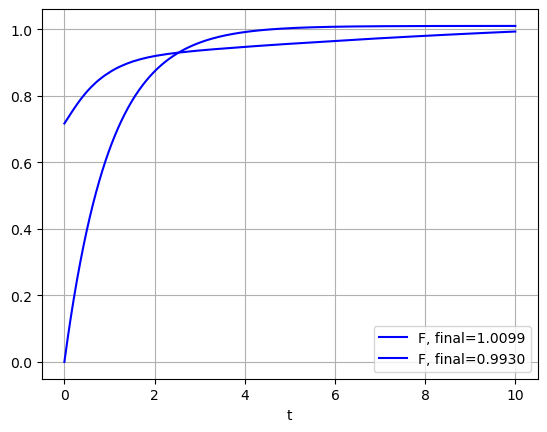

at epoch 5000,  total loss: 2529.97494141 Res F: 2528.50898361, F(T_0): 1.46306938
 F(T_inf): 0.00288241, dFdt(T_inf): 0.00000023
 RHS F: 0.00000577
Time taken: 7.55s

Start of epoch 5200
at epoch 5200,  total loss: 2533.08786759 Res F: 2531.62334442, F(T_0): 1.46166927
 F(T_inf): 0.00284797, dFdt(T_inf): 0.00000023
 RHS F: 0.00000571
Time taken: 7.46s

Start of epoch 5400
at epoch 5400,  total loss: 2536.52531277 Res F: 2535.06227112, F(T_0): 1.46021414
 F(T_inf): 0.00282163, dFdt(T_inf): 0.00000023
 RHS F: 0.00000565
Time taken: 7.51s

Start of epoch 5600
at epoch 5600,  total loss: 2538.82536415 Res F: 2537.36321259, F(T_0): 1.45934600
 F(T_inf): 0.00279972, dFdt(T_inf): 0.00000024
 RHS F: 0.00000561
Time taken: 7.50s

Start of epoch 5800
at epoch 5800,  total loss: 2539.20140504 Res F: 2537.74003220, F(T_0): 1.45858532
 F(T_inf): 0.00278171, dFdt(T_inf): 0.00000024
 RHS F: 0.00000557
Time taken: 7.51s

Start of epoch 6000


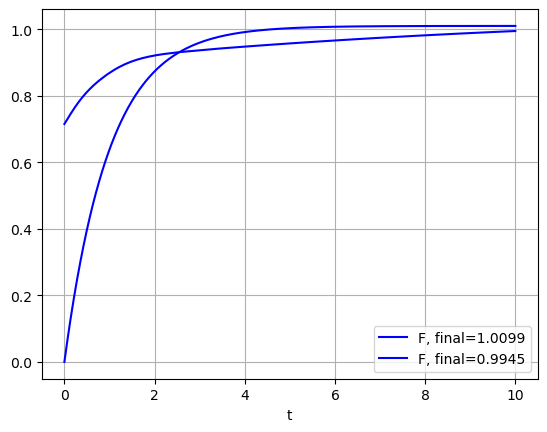

at epoch 6000,  total loss: 2540.43106821 Res F: 2538.97020721, F(T_0): 1.45808506
 F(T_inf): 0.00277015, dFdt(T_inf): 0.00000024
 RHS F: 0.00000555
Time taken: 7.63s

Start of epoch 6200
at epoch 6200,  total loss: 2539.71064594 Res F: 2538.25008392, F(T_0): 1.45779455
 F(T_inf): 0.00276170, dFdt(T_inf): 0.00000024
 RHS F: 0.00000553
Time taken: 7.44s

Start of epoch 6400
at epoch 6400,  total loss: 2541.77677956 Res F: 2540.31663132, F(T_0): 1.45737332
 F(T_inf): 0.00276914, dFdt(T_inf): 0.00000024
 RHS F: 0.00000555
Time taken: 7.42s

Start of epoch 6600
at epoch 6600,  total loss: 2545.65211732 Res F: 2544.19266891, F(T_0): 1.45662713
 F(T_inf): 0.00281538, dFdt(T_inf): 0.00000025
 RHS F: 0.00000564
Time taken: 7.49s

Start of epoch 6800
at epoch 6800,  total loss: 2555.52917348 Res F: 2554.07156372, F(T_0): 1.45466399
 F(T_inf): 0.00293960, dFdt(T_inf): 0.00000027
 RHS F: 0.00000589
Time taken: 7.46s

Start of epoch 7000


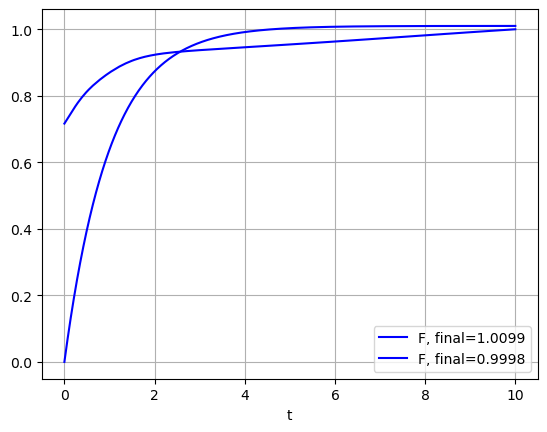

at epoch 7000,  total loss: 2569.95961306 Res F: 2568.50462341, F(T_0): 1.45185655
 F(T_inf): 0.00312654, dFdt(T_inf): 0.00000029
 RHS F: 0.00000626
Time taken: 7.62s

Start of epoch 7200
at epoch 7200,  total loss: 2581.55855149 Res F: 2580.10609436, F(T_0): 1.44915652
 F(T_inf): 0.00329375, dFdt(T_inf): 0.00000026
 RHS F: 0.00000660
Time taken: 7.37s

Start of epoch 7400
at epoch 7400,  total loss: 2592.97224432 Res F: 2591.52209473, F(T_0): 1.44671953
 F(T_inf): 0.00342301, dFdt(T_inf): 0.00000020
 RHS F: 0.00000686
Time taken: 7.49s

Start of epoch 7600
at epoch 7600,  total loss: 2602.32736407 Res F: 2600.87921906, F(T_0): 1.44460452
 F(T_inf): 0.00353325, dFdt(T_inf): 0.00000017
 RHS F: 0.00000708
Time taken: 7.48s

Start of epoch 7800
at epoch 7800,  total loss: 2610.47365933 Res F: 2609.02716064, F(T_0): 1.44285220
 F(T_inf): 0.00363902, dFdt(T_inf): 0.00000017
 RHS F: 0.00000729
Time taken: 7.46s

Start of epoch 8000


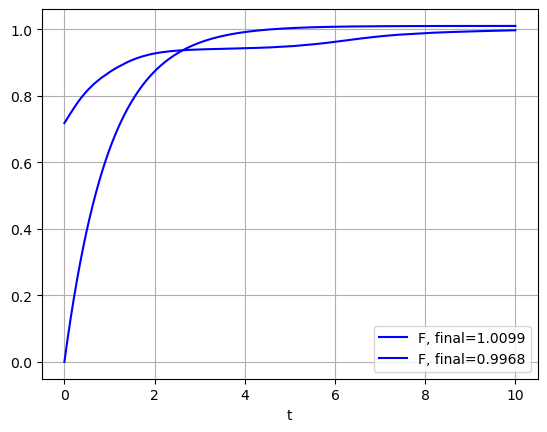

at epoch 8000,  total loss: 2620.61288727 Res F: 2619.16821289, F(T_0): 1.44090688
 F(T_inf): 0.00375979, dFdt(T_inf): 0.00000018
 RHS F: 0.00000753
Time taken: 7.92s

Start of epoch 8200
at epoch 8200,  total loss: 2626.69479354 Res F: 2625.25160217, F(T_0): 1.43925923
 F(T_inf): 0.00392402, dFdt(T_inf): 0.00000026
 RHS F: 0.00000786
Time taken: 7.48s

Start of epoch 8400
at epoch 8400,  total loss: 2638.07930066 Res F: 2636.63851929, F(T_0): 1.43662512
 F(T_inf): 0.00414757, dFdt(T_inf): 0.00000037
 RHS F: 0.00000831
Time taken: 7.48s

Start of epoch 8600
at epoch 8600,  total loss: 2645.24776729 Res F: 2643.80866241, F(T_0): 1.43471169
 F(T_inf): 0.00438394, dFdt(T_inf): 0.00000046
 RHS F: 0.00000878
Time taken: 7.64s

Start of epoch 8800
at epoch 8800,  total loss: 2652.58426319 Res F: 2651.14621735, F(T_0): 1.43344808
 F(T_inf): 0.00458816, dFdt(T_inf): 0.00000042
 RHS F: 0.00000919
Time taken: 7.54s

Start of epoch 9000


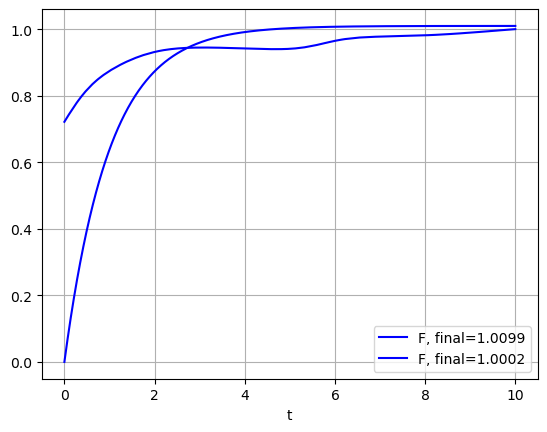

at epoch 9000,  total loss: 2659.43187061 Res F: 2657.99520874, F(T_0): 1.43189514
 F(T_inf): 0.00475688, dFdt(T_inf): 0.00000033
 RHS F: 0.00000953
Time taken: 7.65s

Start of epoch 9200
at epoch 9200,  total loss: 2662.42312438 Res F: 2660.98768616, F(T_0): 1.43047458
 F(T_inf): 0.00495342, dFdt(T_inf): 0.00000030
 RHS F: 0.00000992
Time taken: 7.36s

Start of epoch 9400
at epoch 9400,  total loss: 2671.53808469 Res F: 2670.10426331, F(T_0): 1.42869556
 F(T_inf): 0.00511530, dFdt(T_inf): 0.00000029
 RHS F: 0.00001024
Time taken: 7.53s

Start of epoch 9600
at epoch 9600,  total loss: 2673.89495018 Res F: 2672.46188354, F(T_0): 1.42785066
 F(T_inf): 0.00520527, dFdt(T_inf): 0.00000028
 RHS F: 0.00001042
Time taken: 7.53s

Start of epoch 9800
at epoch 9800,  total loss: 2677.78635456 Res F: 2676.35403442, F(T_0): 1.42700857
 F(T_inf): 0.00530067, dFdt(T_inf): 0.00000028
 RHS F: 0.00001061
Time taken: 7.48s

Start of epoch 10000


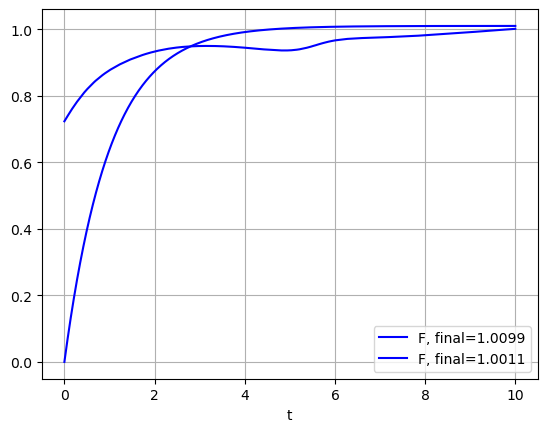

at epoch 10000,  total loss: 2663.31805168 Res F: 2661.88503265, F(T_0): 1.42761922
 F(T_inf): 0.00538874, dFdt(T_inf): 0.00000028
 RHS F: 0.00001079
Time taken: 7.54s

Start of epoch 10200
at epoch 10200,  total loss: 2586.33675131 Res F: 2584.89655304, F(T_0): 1.43471956
 F(T_inf): 0.00546749, dFdt(T_inf): 0.00000027
 RHS F: 0.00001095
Time taken: 7.45s

Start of epoch 10400
at epoch 10400,  total loss: 2661.79636071 Res F: 2660.36388397, F(T_0): 1.42684460
 F(T_inf): 0.00562062, dFdt(T_inf): 0.00000026
 RHS F: 0.00001125
Time taken: 7.39s

Start of epoch 10600
at epoch 10600,  total loss: 2691.76159508 Res F: 2690.33237457, F(T_0): 1.42346805
 F(T_inf): 0.00574070, dFdt(T_inf): 0.00000026
 RHS F: 0.00001149
Time taken: 7.40s

Start of epoch 10800
at epoch 10800,  total loss: 2669.14481819 Res F: 2667.71422577, F(T_0): 1.42480028
 F(T_inf): 0.00578032, dFdt(T_inf): 0.00000025
 RHS F: 0.00001157
Time taken: 7.41s

Start of epoch 11000


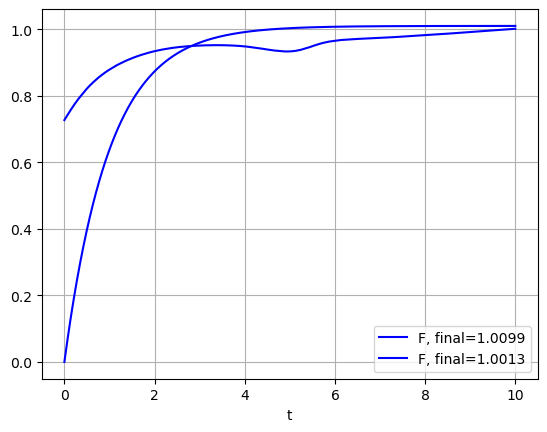

at epoch 11000,  total loss: 2704.20628005 Res F: 2702.77844238, F(T_0): 1.42193609
 F(T_inf): 0.00588953, dFdt(T_inf): 0.00000025
 RHS F: 0.00001179
Time taken: 7.71s

Start of epoch 11200
at epoch 11200,  total loss: 2699.98676084 Res F: 2698.55886078, F(T_0): 1.42194861
 F(T_inf): 0.00593932, dFdt(T_inf): 0.00000024
 RHS F: 0.00001189
Time taken: 7.46s

Start of epoch 11400
at epoch 11400,  total loss: 2697.81375240 Res F: 2696.38579559, F(T_0): 1.42197114
 F(T_inf): 0.00597347, dFdt(T_inf): 0.00000023
 RHS F: 0.00001196
Time taken: 7.56s

Start of epoch 11600
at epoch 11600,  total loss: 2645.55209857 Res F: 2644.11923218, F(T_0): 1.42687190
 F(T_inf): 0.00598229, dFdt(T_inf): 0.00000023
 RHS F: 0.00001198
Time taken: 7.53s

Start of epoch 11800
at epoch 11800,  total loss: 2733.97854536 Res F: 2732.55433655, F(T_0): 1.41816705
 F(T_inf): 0.00602946, dFdt(T_inf): 0.00000022
 RHS F: 0.00001207
Time taken: 7.45s

Start of epoch 12000


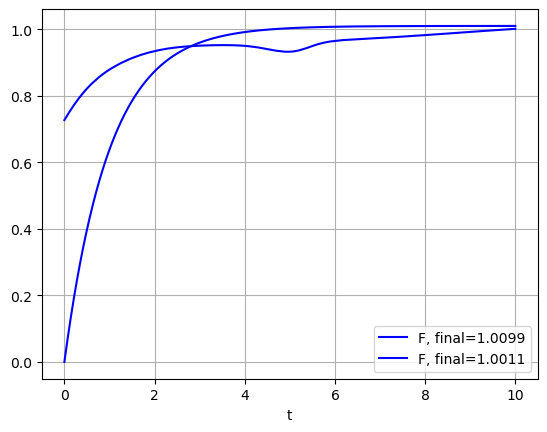

at epoch 12000,  total loss: 2704.90194400 Res F: 2703.47486115, F(T_0): 1.42103684
 F(T_inf): 0.00603372, dFdt(T_inf): 0.00000022
 RHS F: 0.00001208
Time taken: 7.62s

Start of epoch 12200
at epoch 12200,  total loss: 2737.67239192 Res F: 2736.24851990, F(T_0): 1.41780794
 F(T_inf): 0.00605176, dFdt(T_inf): 0.00000021
 RHS F: 0.00001212
Time taken: 7.58s

Start of epoch 12400
at epoch 12400,  total loss: 2692.19666771 Res F: 2690.76847076, F(T_0): 1.42214054
 F(T_inf): 0.00604409, dFdt(T_inf): 0.00000021
 RHS F: 0.00001210
Time taken: 7.54s

Start of epoch 12600
at epoch 12600,  total loss: 2714.39792906 Res F: 2712.97224426, F(T_0): 1.41961718
 F(T_inf): 0.00605529, dFdt(T_inf): 0.00000021
 RHS F: 0.00001212
Time taken: 7.49s

Start of epoch 12800
at epoch 12800,  total loss: 2678.90902524 Res F: 2677.47988892, F(T_0): 1.42307115
 F(T_inf): 0.00605285, dFdt(T_inf): 0.00000021
 RHS F: 0.00001212
Time taken: 7.46s

Start of epoch 13000


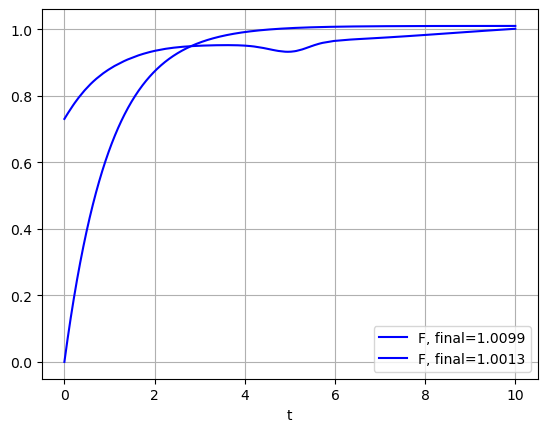

at epoch 13000,  total loss: 2752.44013413 Res F: 2751.01801300, F(T_0): 1.41603231
 F(T_inf): 0.00607644, dFdt(T_inf): 0.00000021
 RHS F: 0.00001217
Time taken: 7.67s

Start of epoch 13200
at epoch 13200,  total loss: 2693.94113559 Res F: 2692.51362610, F(T_0): 1.42143518
 F(T_inf): 0.00606197, dFdt(T_inf): 0.00000021
 RHS F: 0.00001214
Time taken: 7.57s

Start of epoch 13400
at epoch 13400,  total loss: 2728.82729643 Res F: 2727.40306091, F(T_0): 1.41814446
 F(T_inf): 0.00607867, dFdt(T_inf): 0.00000021
 RHS F: 0.00001217
Time taken: 7.48s

Start of epoch 13600
at epoch 13600,  total loss: 2571.64067608 Res F: 2570.20140076, F(T_0): 1.43323421
 F(T_inf): 0.00602883, dFdt(T_inf): 0.00000021
 RHS F: 0.00001207
Time taken: 7.44s

Start of epoch 13800
at epoch 13800,  total loss: 2689.88174955 Res F: 2688.45405579, F(T_0): 1.42163098
 F(T_inf): 0.00605046, dFdt(T_inf): 0.00000021
 RHS F: 0.00001211
Time taken: 7.52s

Start of epoch 14000


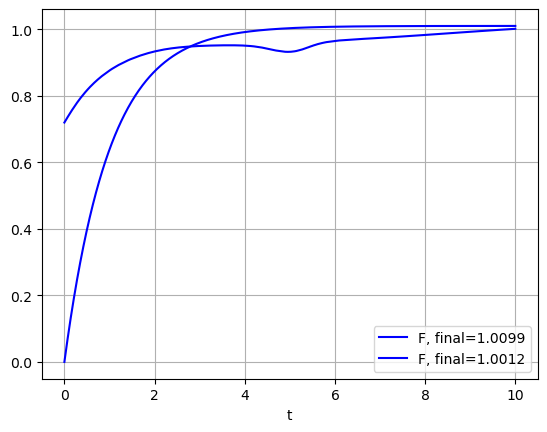

at epoch 14000,  total loss: 2604.71458188 Res F: 2603.27835083, F(T_0): 1.43018490
 F(T_inf): 0.00603386, dFdt(T_inf): 0.00000021
 RHS F: 0.00001208
Time taken: 7.54s

Start of epoch 14200
at epoch 14200,  total loss: 2699.92988621 Res F: 2698.50314331, F(T_0): 1.42066932
 F(T_inf): 0.00606124, dFdt(T_inf): 0.00000021
 RHS F: 0.00001214
Time taken: 7.54s

Start of epoch 14400
at epoch 14400,  total loss: 2723.25789346 Res F: 2721.83360291, F(T_0): 1.41821998
 F(T_inf): 0.00605823, dFdt(T_inf): 0.00000021
 RHS F: 0.00001213
Time taken: 7.43s

Start of epoch 14600
at epoch 14600,  total loss: 2718.32724303 Res F: 2716.90263367, F(T_0): 1.41851079
 F(T_inf): 0.00608585, dFdt(T_inf): 0.00000054
 RHS F: 0.00001218
Time taken: 7.43s

Start of epoch 14800
at epoch 14800,  total loss: 2710.21171128 Res F: 2708.78648376, F(T_0): 1.41909486
 F(T_inf): 0.00611951, dFdt(T_inf): 0.00000089
 RHS F: 0.00001225
Time taken: 7.46s

Start of epoch 15000


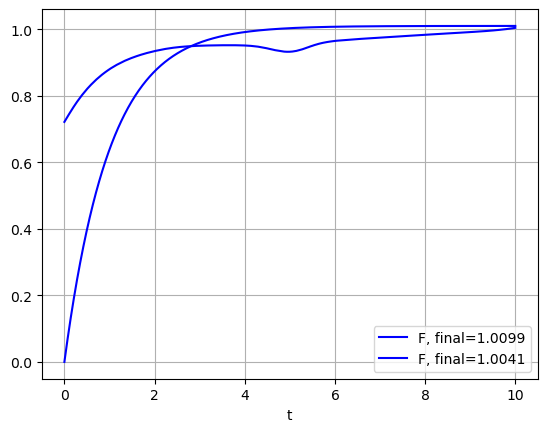

at epoch 15000,  total loss: 2646.58646148 Res F: 2645.15385437, F(T_0): 1.42639947
 F(T_inf): 0.00619421, dFdt(T_inf): 0.00000102
 RHS F: 0.00001240
Time taken: 7.61s

Start of epoch 15200
at epoch 15200,  total loss: 2710.21455242 Res F: 2708.78917694, F(T_0): 1.41920012
 F(T_inf): 0.00616207, dFdt(T_inf): 0.00000095
 RHS F: 0.00001234
Time taken: 7.51s

Start of epoch 15400
at epoch 15400,  total loss: 2722.02156221 Res F: 2720.59785461, F(T_0): 1.41754979
 F(T_inf): 0.00614462, dFdt(T_inf): 0.00000088
 RHS F: 0.00001230
Time taken: 7.42s

Start of epoch 15600
at epoch 15600,  total loss: 2711.27602191 Res F: 2709.85137939, F(T_0): 1.41848224
 F(T_inf): 0.00614715, dFdt(T_inf): 0.00000082
 RHS F: 0.00001231
Time taken: 7.45s

Start of epoch 15800
at epoch 15800,  total loss: 2700.00162222 Res F: 2698.57617950, F(T_0): 1.41927552
 F(T_inf): 0.00615411, dFdt(T_inf): 0.00000077
 RHS F: 0.00001232
Time taken: 7.46s

Start of epoch 16000


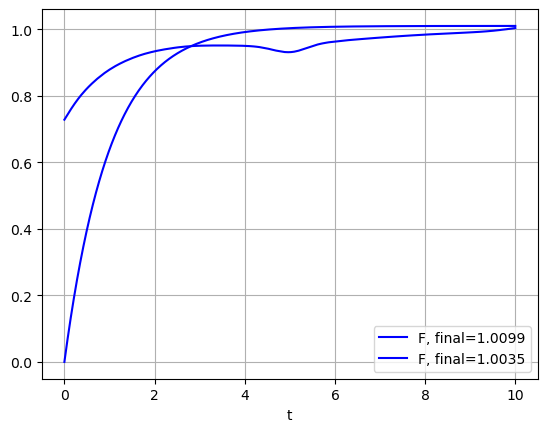

at epoch 16000,  total loss: 2719.61467526 Res F: 2718.19169617, F(T_0): 1.41678655
 F(T_inf): 0.00617945, dFdt(T_inf): 0.00000072
 RHS F: 0.00001237
Time taken: 7.58s

Start of epoch 16200
at epoch 16200,  total loss: 2730.16421451 Res F: 2728.74154663, F(T_0): 1.41637796
 F(T_inf): 0.00627663, dFdt(T_inf): 0.00000071
 RHS F: 0.00001257
Time taken: 7.47s

Start of epoch 16400
at epoch 16400,  total loss: 2689.99433427 Res F: 2688.56813049, F(T_0): 1.41988790
 F(T_inf): 0.00630253, dFdt(T_inf): 0.00000073
 RHS F: 0.00001262
Time taken: 7.47s

Start of epoch 16600
at epoch 16600,  total loss: 2731.99389958 Res F: 2730.57167816, F(T_0): 1.41586101
 F(T_inf): 0.00634698, dFdt(T_inf): 0.00000073
 RHS F: 0.00001271
Time taken: 7.60s

Start of epoch 16800
at epoch 16800,  total loss: 2722.05839597 Res F: 2720.63584900, F(T_0): 1.41620219
 F(T_inf): 0.00633137, dFdt(T_inf): 0.00000073
 RHS F: 0.00001268
Time taken: 7.46s

Start of epoch 17000


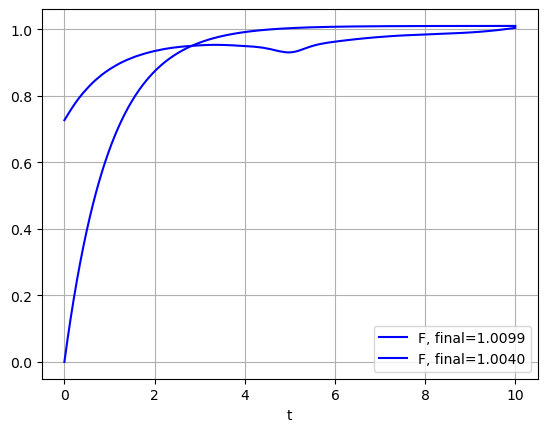

at epoch 17000,  total loss: 2698.84304182 Res F: 2697.41790771, F(T_0): 1.41874844
 F(T_inf): 0.00637217, dFdt(T_inf): 0.00000074
 RHS F: 0.00001276
Time taken: 7.56s

Start of epoch 17200
at epoch 17200,  total loss: 2721.56610761 Res F: 2720.14353943, F(T_0): 1.41615361
 F(T_inf): 0.00640105, dFdt(T_inf): 0.00000071
 RHS F: 0.00001282
Time taken: 7.49s

Start of epoch 17400
at epoch 17400,  total loss: 2729.77143873 Res F: 2728.34962463, F(T_0): 1.41539037
 F(T_inf): 0.00641015, dFdt(T_inf): 0.00000074
 RHS F: 0.00001283
Time taken: 7.50s

Start of epoch 17600
at epoch 17600,  total loss: 2723.15854887 Res F: 2721.73634338, F(T_0): 1.41578144
 F(T_inf): 0.00641049, dFdt(T_inf): 0.00000072
 RHS F: 0.00001283
Time taken: 7.44s

Start of epoch 17800
at epoch 17800,  total loss: 2743.06481918 Res F: 2741.64458466, F(T_0): 1.41380793
 F(T_inf): 0.00641302, dFdt(T_inf): 0.00000074
 RHS F: 0.00001284
Time taken: 7.55s

Start of epoch 18000


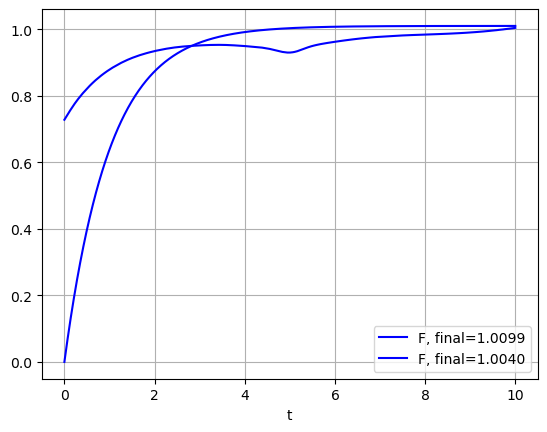

at epoch 18000,  total loss: 2719.37986578 Res F: 2717.95774841, F(T_0): 1.41569734
 F(T_inf): 0.00640651, dFdt(T_inf): 0.00000070
 RHS F: 0.00001283
Time taken: 7.53s

Start of epoch 18200
at epoch 18200,  total loss: 2698.11525057 Res F: 2696.69085693, F(T_0): 1.41795057
 F(T_inf): 0.00642949, dFdt(T_inf): 0.00000070
 RHS F: 0.00001287
Time taken: 7.49s

Start of epoch 18400
at epoch 18400,  total loss: 2729.98699610 Res F: 2728.56579590, F(T_0): 1.41473293
 F(T_inf): 0.00645364, dFdt(T_inf): 0.00000071
 RHS F: 0.00001292
Time taken: 7.43s

Start of epoch 18600
at epoch 18600,  total loss: 2700.06962726 Res F: 2698.64554596, F(T_0): 1.41761547
 F(T_inf): 0.00645219, dFdt(T_inf): 0.00000072
 RHS F: 0.00001292
Time taken: 7.55s

Start of epoch 18800
at epoch 18800,  total loss: 2697.94179373 Res F: 2696.51809692, F(T_0): 1.41725737
 F(T_inf): 0.00642584, dFdt(T_inf): 0.00000073
 RHS F: 0.00001287
Time taken: 7.41s

Start of epoch 19000


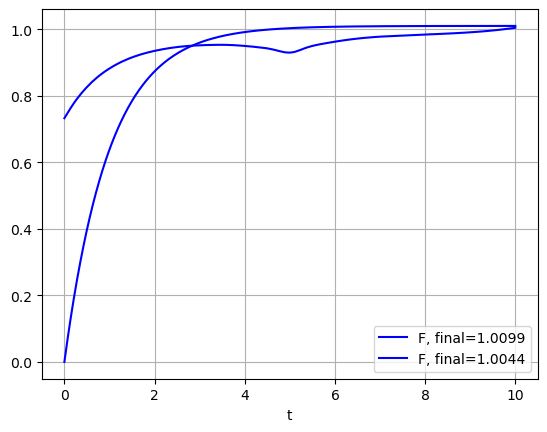

at epoch 19000,  total loss: 2782.66986108 Res F: 2781.25401306, F(T_0): 1.40934634
 F(T_inf): 0.00648789, dFdt(T_inf): 0.00000080
 RHS F: 0.00001299
Time taken: 7.55s

Start of epoch 19200
at epoch 19200,  total loss: 2731.10116262 Res F: 2729.68061829, F(T_0): 1.41405243
 F(T_inf): 0.00647811, dFdt(T_inf): 0.00000083
 RHS F: 0.00001297
Time taken: 7.43s

Start of epoch 19400
at epoch 19400,  total loss: 2732.37469732 Res F: 2730.95343781, F(T_0): 1.41471809
 F(T_inf): 0.00652745, dFdt(T_inf): 0.00000091
 RHS F: 0.00001307
Time taken: 7.53s

Start of epoch 19600
at epoch 19600,  total loss: 2652.98453213 Res F: 2651.55593872, F(T_0): 1.42206776
 F(T_inf): 0.00651174, dFdt(T_inf): 0.00000087
 RHS F: 0.00001304
Time taken: 7.49s

Start of epoch 19800
at epoch 19800,  total loss: 2753.98675523 Res F: 2752.56853485, F(T_0): 1.41169304
 F(T_inf): 0.00651341, dFdt(T_inf): 0.00000090
 RHS F: 0.00001304
Time taken: 7.41s

Start of epoch 20000


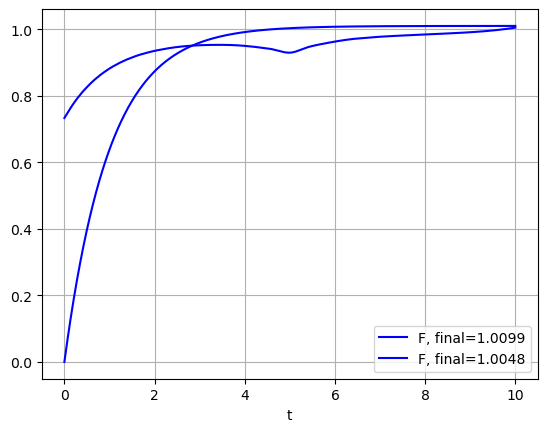

at epoch 20000,  total loss: 2774.35249146 Res F: 2772.93622589, F(T_0): 1.40972239
 F(T_inf): 0.00652921, dFdt(T_inf): 0.00000090
 RHS F: 0.00001307
Time taken: 7.67s


In [476]:
def epoch_callback(epoch, loss_samples, index):
    if epoch%1000 == 0:
        pred = pinn.net(t[:, np.newaxis].astype(np.float32))
        pred_F = pred[:, 0]
        #pred_E = pred[:, 1]
        plt.plot(t, sol[:, 0], 'b', label=f"F, final={sol[-1, 0]:.4f}")
        #plt.plot(t, sol[:, 1], 'g', label=f"E, final={sol[-1, 1]:.4f}")
        plt.plot(t, pred_F, 'b', label=f"F, final={pred_F[-1]:.4f}")
        #plt.plot(t, pred_E, 'g', label=f"E, final={pred_E[-1]:.4f}")

        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()
        
    
losses = tu.train(epochs=20000+1,
                  batch_size=500,
                  dataset = ds ,
                  train_step = train_step,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=epoch_callback)


Start of epoch 0


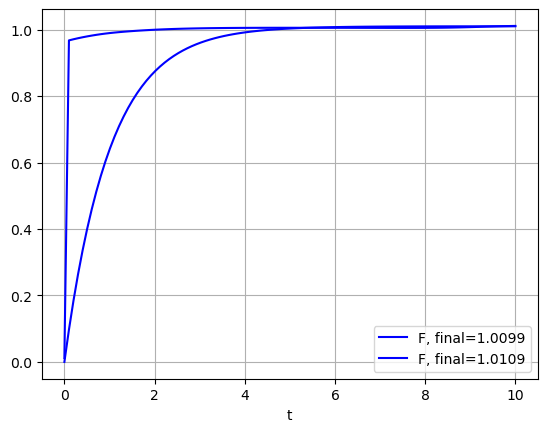

at epoch 0,  total loss: 100.19295219 Res F: 100.19281006, F(T_0): 0.00014089
 F(T_inf): 0.00000118, dFdt(T_inf): 0.00000005
 RHS F: 0.00000001
Time taken: 0.30s

Start of epoch 100
at epoch 100,  total loss: 99.97260023 Res F: 99.97246552, F(T_0): 0.00013353
 F(T_inf): 0.00000114, dFdt(T_inf): 0.00000004
 RHS F: 0.00000001
Time taken: 2.28s

Start of epoch 200
at epoch 200,  total loss: 99.84536519 Res F: 99.84523773, F(T_0): 0.00012634
 F(T_inf): 0.00000108, dFdt(T_inf): 0.00000003
 RHS F: 0.00000001
Time taken: 2.41s

Start of epoch 300
at epoch 300,  total loss: 99.78330874 Res F: 99.78318787, F(T_0): 0.00011982
 F(T_inf): 0.00000102, dFdt(T_inf): 0.00000003
 RHS F: 0.00000001
Time taken: 2.36s

Start of epoch 400
at epoch 400,  total loss: 99.76142981 Res F: 99.76131439, F(T_0): 0.00011441
 F(T_inf): 0.00000097, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.30s

Start of epoch 500


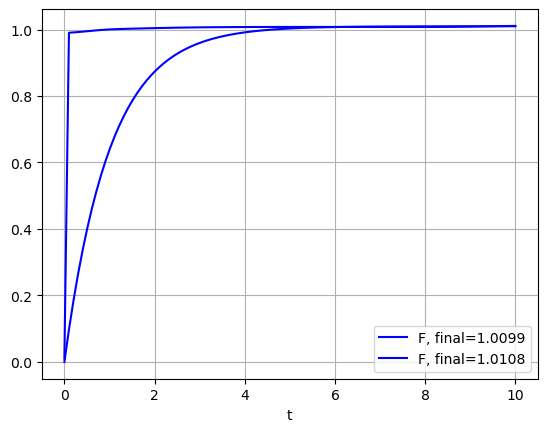

at epoch 500,  total loss: 99.76048714 Res F: 99.76037598, F(T_0): 0.00011020
 F(T_inf): 0.00000094, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.42s

Start of epoch 600
at epoch 600,  total loss: 99.76979174 Res F: 99.76968384, F(T_0): 0.00010697
 F(T_inf): 0.00000091, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.31s

Start of epoch 700
at epoch 700,  total loss: 99.78079099 Res F: 99.78068542, F(T_0): 0.00010464
 F(T_inf): 0.00000090, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.33s

Start of epoch 800
at epoch 800,  total loss: 99.79090593 Res F: 99.79080200, F(T_0): 0.00010302
 F(T_inf): 0.00000089, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.27s

Start of epoch 900
at epoch 900,  total loss: 99.79997606 Res F: 99.79987335, F(T_0): 0.00010181
 F(T_inf): 0.00000088, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.35s

Start of epoch 1000


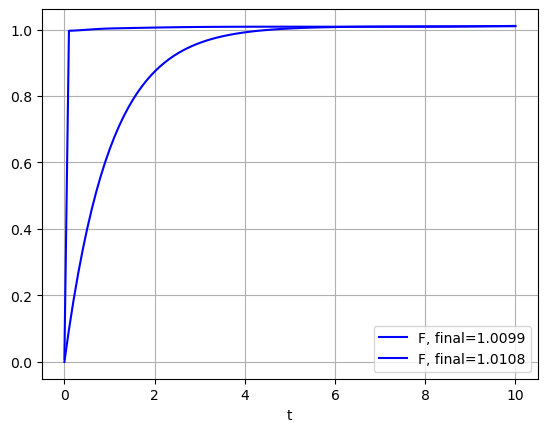

at epoch 1000,  total loss: 99.80556768 Res F: 99.80546570, F(T_0): 0.00010108
 F(T_inf): 0.00000088, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.44s

Start of epoch 1100
at epoch 1100,  total loss: 99.81025156 Res F: 99.81015015, F(T_0): 0.00010052
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.28s

Start of epoch 1200
at epoch 1200,  total loss: 99.81295965 Res F: 99.81285858, F(T_0): 0.00010018
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.33s

Start of epoch 1300
at epoch 1300,  total loss: 99.81501934 Res F: 99.81491852, F(T_0): 0.00009993
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.30s

Start of epoch 1400
at epoch 1400,  total loss: 99.81584319 Res F: 99.81574249, F(T_0): 0.00009981
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.36s

Start of epoch 1500


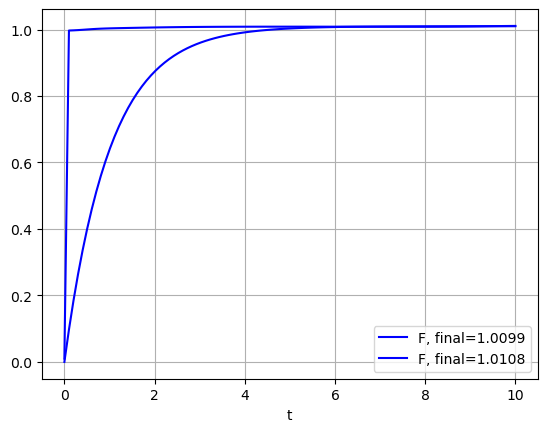

at epoch 1500,  total loss: 99.81551511 Res F: 99.81541443, F(T_0): 0.00009979
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.41s

Start of epoch 1600
at epoch 1600,  total loss: 99.81627794 Res F: 99.81617737, F(T_0): 0.00009968
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.33s

Start of epoch 1700
at epoch 1700,  total loss: 99.81606431 Res F: 99.81596375, F(T_0): 0.00009968
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.36s

Start of epoch 1800
at epoch 1800,  total loss: 99.81567521 Res F: 99.81557465, F(T_0): 0.00009968
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.32s

Start of epoch 1900
at epoch 1900,  total loss: 99.81754420 Res F: 99.81744385, F(T_0): 0.00009947
 F(T_inf): 0.00000086, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.33s

Start of epoch 2000


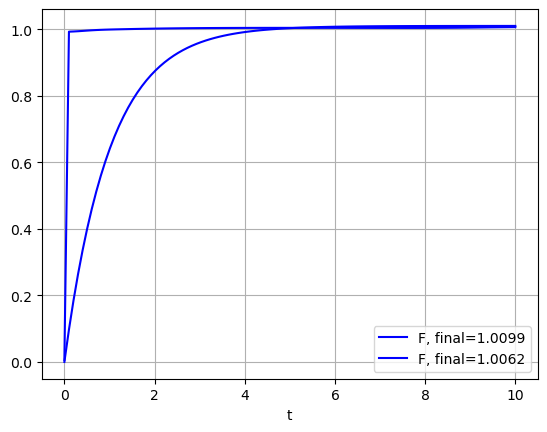

at epoch 2000,  total loss: 99.11646164 Res F: 99.11624146, F(T_0): 0.00019420
 F(T_inf): 0.00002572, dFdt(T_inf): 0.00000001
 RHS F: 0.00000025
Time taken: 2.45s

Start of epoch 2100
at epoch 2100,  total loss: 101.77647443 Res F: 101.77642822, F(T_0): 0.00000996
 F(T_inf): 0.00003587, dFdt(T_inf): 0.00000001
 RHS F: 0.00000036
Time taken: 2.34s

Start of epoch 2200
at epoch 2200,  total loss: 99.00854128 Res F: 99.00829315, F(T_0): 0.00021627
 F(T_inf): 0.00003154, dFdt(T_inf): 0.00000002
 RHS F: 0.00000031
Time taken: 2.34s

Start of epoch 2300
at epoch 2300,  total loss: 99.98946473 Res F: 99.98937988, F(T_0): 0.00008481
 F(T_inf): 0.00000002, dFdt(T_inf): 0.00000002
 RHS F: 0.00000000
Time taken: 2.30s

Start of epoch 2400
at epoch 2400,  total loss: 99.91519118 Res F: 99.91510010, F(T_0): 0.00009085
 F(T_inf): 0.00000021, dFdt(T_inf): 0.00000002
 RHS F: 0.00000000
Time taken: 2.38s

Start of epoch 2500


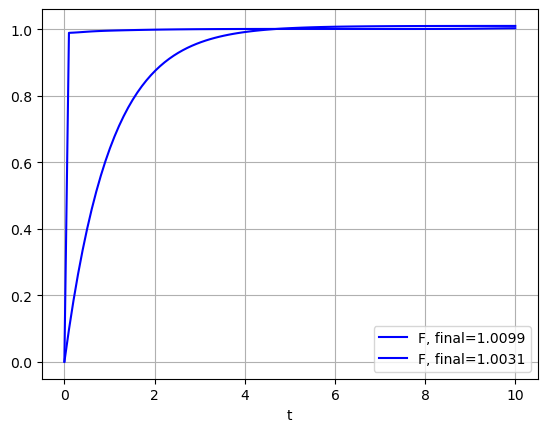

at epoch 2500,  total loss: 98.84856313 Res F: 98.84825134, F(T_0): 0.00026072
 F(T_inf): 0.00005055, dFdt(T_inf): 0.00000002
 RHS F: 0.00000050
Time taken: 2.41s

Start of epoch 2600
at epoch 2600,  total loss: 99.90013205 Res F: 99.90003967, F(T_0): 0.00009209
 F(T_inf): 0.00000028, dFdt(T_inf): 0.00000002
 RHS F: 0.00000000
Time taken: 2.32s

Start of epoch 2700
at epoch 2700,  total loss: 99.87149390 Res F: 99.87139893, F(T_0): 0.00009451
 F(T_inf): 0.00000044, dFdt(T_inf): 0.00000002
 RHS F: 0.00000000
Time taken: 2.34s

Start of epoch 2800
at epoch 2800,  total loss: 99.99030384 Res F: 99.99021912, F(T_0): 0.00008469
 F(T_inf): 0.00000002, dFdt(T_inf): 0.00000002
 RHS F: 0.00000000
Time taken: 2.36s

Start of epoch 2900
at epoch 2900,  total loss: 99.81491211 Res F: 99.81481171, F(T_0): 0.00009954
 F(T_inf): 0.00000084, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.35s

Start of epoch 3000


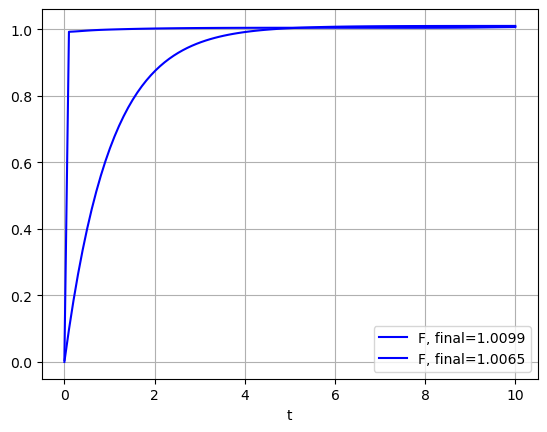

at epoch 3000,  total loss: 99.42244597 Res F: 99.42229462, F(T_0): 0.00014316
 F(T_inf): 0.00000810, dFdt(T_inf): 0.00000002
 RHS F: 0.00000008
Time taken: 2.51s

Start of epoch 3100
at epoch 3100,  total loss: 99.80674183 Res F: 99.80664062, F(T_0): 0.00010027
 F(T_inf): 0.00000091, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.38s

Start of epoch 3200
at epoch 3200,  total loss: 99.38709727 Res F: 99.38694000, F(T_0): 0.00014758
 F(T_inf): 0.00000958, dFdt(T_inf): 0.00000002
 RHS F: 0.00000009
Time taken: 2.30s

Start of epoch 3300
at epoch 3300,  total loss: 99.72635177 Res F: 99.72624207, F(T_0): 0.00010793
 F(T_inf): 0.00000175, dFdt(T_inf): 0.00000002
 RHS F: 0.00000002
Time taken: 2.31s

Start of epoch 3400
at epoch 3400,  total loss: 99.81307357 Res F: 99.81297302, F(T_0): 0.00009966
 F(T_inf): 0.00000086, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.36s

Start of epoch 3500


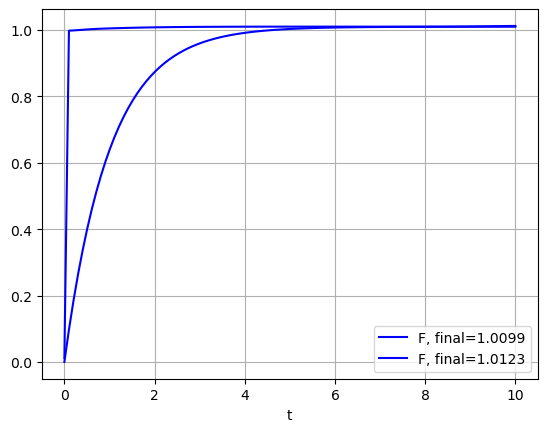

at epoch 3500,  total loss: 101.81684957 Res F: 101.81680298, F(T_0): 0.00000890
 F(T_inf): 0.00003729, dFdt(T_inf): 0.00000002
 RHS F: 0.00000038
Time taken: 2.43s

Start of epoch 3600
at epoch 3600,  total loss: 99.80143990 Res F: 99.80133820, F(T_0): 0.00010072
 F(T_inf): 0.00000096, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.38s

Start of epoch 3700
at epoch 3700,  total loss: 99.81194452 Res F: 99.81184387, F(T_0): 0.00009974
 F(T_inf): 0.00000088, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.33s

Start of epoch 3800
at epoch 3800,  total loss: 98.71758651 Res F: 98.71719360, F(T_0): 0.00031814
 F(T_inf): 0.00007402, dFdt(T_inf): 0.00000002
 RHS F: 0.00000073
Time taken: 2.34s

Start of epoch 3900
at epoch 3900,  total loss: 99.81652932 Res F: 99.81642914, F(T_0): 0.00009933
 F(T_inf): 0.00000083, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.35s

Start of epoch 4000


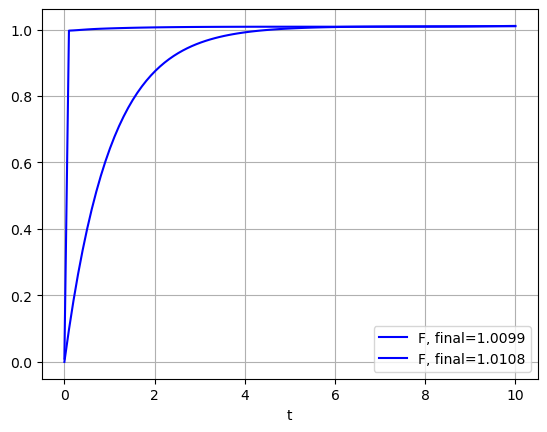

at epoch 4000,  total loss: 99.81203605 Res F: 99.81193542, F(T_0): 0.00009972
 F(T_inf): 0.00000088, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.50s

Start of epoch 4100
at epoch 4100,  total loss: 129.00602963 Res F: 129.00296021, F(T_0): 0.00117236
 F(T_inf): 0.00187822, dFdt(T_inf): 0.00000001
 RHS F: 0.00001882
Time taken: 2.40s

Start of epoch 4200
at epoch 4200,  total loss: 99.83258760 Res F: 99.83248901, F(T_0): 0.00009787
 F(T_inf): 0.00000070, dFdt(T_inf): 0.00000002
 RHS F: 0.00000001
Time taken: 2.36s

Start of epoch 4300
at epoch 4300,  total loss: 99.81186058 Res F: 99.81175995, F(T_0): 0.00009973
 F(T_inf): 0.00000087, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.37s

Start of epoch 4400
at epoch 4400,  total loss: 107.49294479 Res F: 107.49253845, F(T_0): 0.00008142
 F(T_inf): 0.00032167, dFdt(T_inf): 0.00000001
 RHS F: 0.00000323
Time taken: 2.37s

Start of epoch 4500


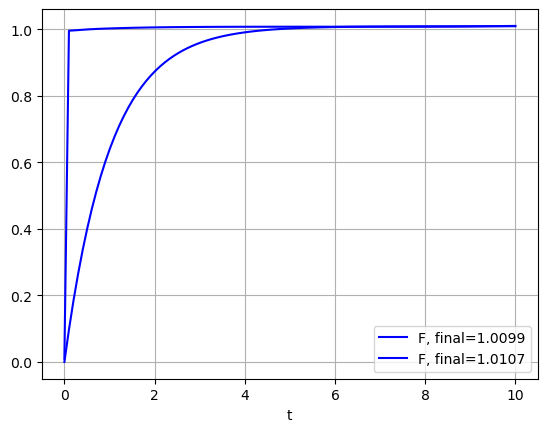

at epoch 4500,  total loss: 99.78899760 Res F: 99.78889465, F(T_0): 0.00010185
 F(T_inf): 0.00000107, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.44s

Start of epoch 4600
at epoch 4600,  total loss: 99.81214283 Res F: 99.81204224, F(T_0): 0.00009970
 F(T_inf): 0.00000088, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.31s

Start of epoch 4700
at epoch 4700,  total loss: 98.95137173 Res F: 98.95110321, F(T_0): 0.00023147
 F(T_inf): 0.00003668, dFdt(T_inf): 0.00000001
 RHS F: 0.00000036
Time taken: 2.34s

Start of epoch 4800
at epoch 4800,  total loss: 99.82050381 Res F: 99.82040405, F(T_0): 0.00009894
 F(T_inf): 0.00000079, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.34s

Start of epoch 4900
at epoch 4900,  total loss: 99.81011362 Res F: 99.81001282, F(T_0): 0.00009987
 F(T_inf): 0.00000090, dFdt(T_inf): 0.00000001
 RHS F: 0.00000001
Time taken: 2.38s

Start of epoch 5000


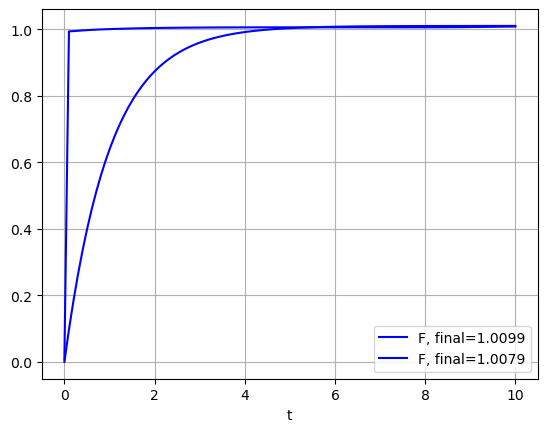

at epoch 5000,  total loss: 99.15700393 Res F: 99.15679932, F(T_0): 0.00018454
 F(T_inf): 0.00001986, dFdt(T_inf): 0.00000001
 RHS F: 0.00000019
Time taken: 2.46s


In [370]:
losses3= tu.train(epochs=5000+1,
                  batch_size=500,
                  dataset = ds ,
                  train_step = train_step,
                  train_step_returns_num = 5,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=epoch_callback)

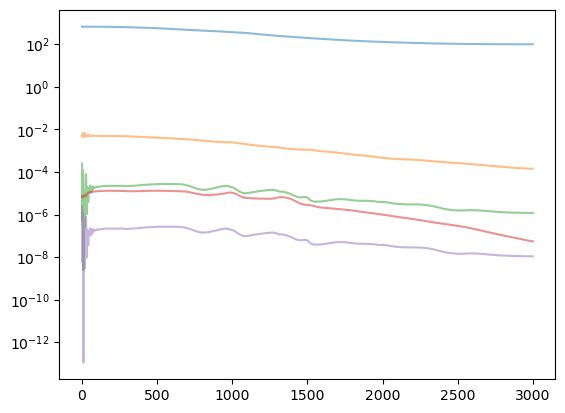

In [369]:
plt.plot(losses2[:,0], alpha=.5)
plt.plot(losses2[:,1], alpha=.5)
plt.plot(losses2[:,2], alpha=.5)
plt.plot(losses2[:,3], alpha=.5)
plt.plot(losses2[:,4], alpha=.5)
#plt.plot(losses[:,5], alpha=.5)
plt.yscale('log')
plt.show()

In [459]:
#pred = pinn.net(t[:, np.newaxis].astype(np.float32))
t2 = 10+np.linspace(.00009,.000001, 1000)[:, np.newaxis].astype(np.float32)
pred = pinn.net(t2)#1/(1+np.exp(-t2))#

pred_F = pred[:, 0]
#pred_E = pred[:, 1]

In [460]:
pred_F.numpy().shape

(1000,)

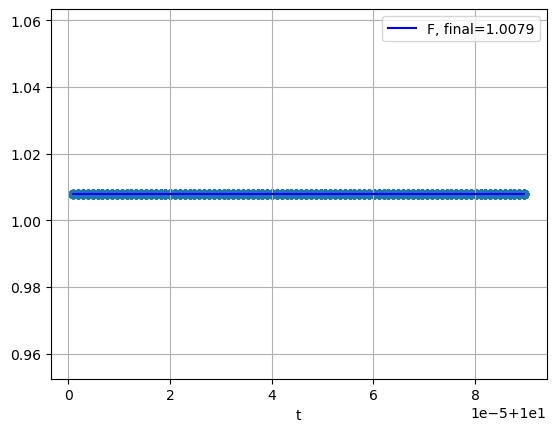

In [461]:
#plt.plot(t, sol[:, 0], 'b', label=f"F, final={sol[-1, 0]:.4f}")
#plt.plot(t, sol[:, 1], 'g', label=f"E, final={sol[-1, 1]:.4f}")
plt.plot(t2, pred_F.numpy(), 'b', label=f"F, final={pred_F[-1]:.4f}")
plt.scatter(t2, pred_F.numpy())
#plt.plot(t, pred_E, 'g', label=f"E, final={pred_E[-1]:.4f}")

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [175]:
@tf.function
def grads(ts):
    with tf.GradientTape(persistent=True) as tape: 
        
        tape.watch(ts)       
        outputs = pinn.net(ts)
        F = tf.squeeze(outputs[:, 0])
        E = tf.squeeze(outputs[:, 1])

        dF_dt = tape.gradient(F, ts)
        dE_dt = tape.gradient(E, ts)        
        
        return (tf.squeeze(F), tf.squeeze(E), tf.squeeze(dF_dt), tf.squeeze(dE_dt))

In [176]:
F, E, dF_dt, dE_dt = grads(t[:, np.newaxis].astype(np.float32))
#F = sol[:, 0]
#E = sol[:, 1]
res_F = mu_F_tf*(1. + V_F_tf/(1. + (K_tf/OC14_tf)**nvd) - F) - dF_dt
res_E = mu_E_tf*(1. + V_E_tf/((1. + (F/K_EF_tf)**nfe)*(1. + (K_EE_tf/E)**nfe)) - E) - dE_dt

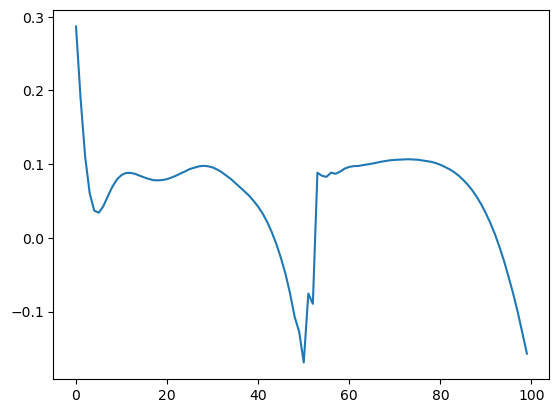

In [177]:
plt.plot(res_F)

In [129]:
np.sum(res_F.numpy()**2)

0.00023208444

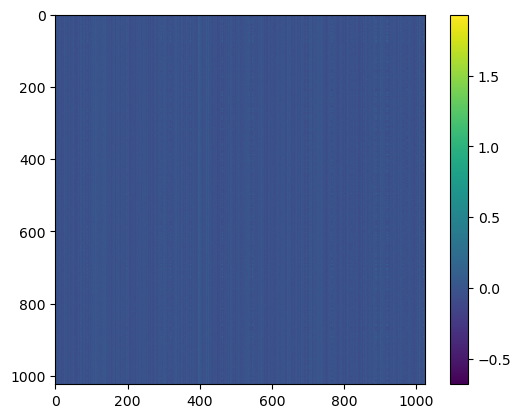

In [445]:
plt.imshow(pinn.weights[1])
plt.colorbar()

(-0.05, 0.05)

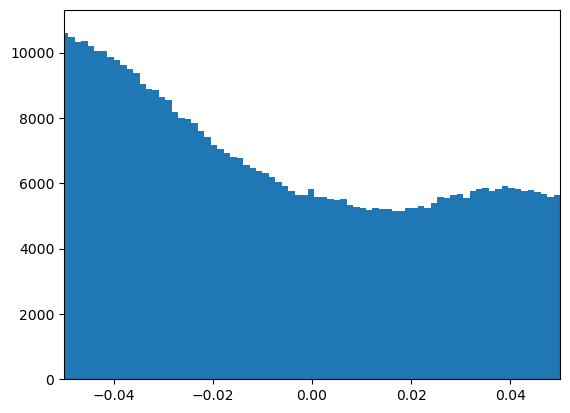

In [451]:
a = plt.hist(pinn.weights[1].numpy().flatten(), bins=2000)
plt.xlim([-.05, .05])

In [452]:
xs = np.linspace(-10, 10)
ys = tf.nn.sigmoid(xs)

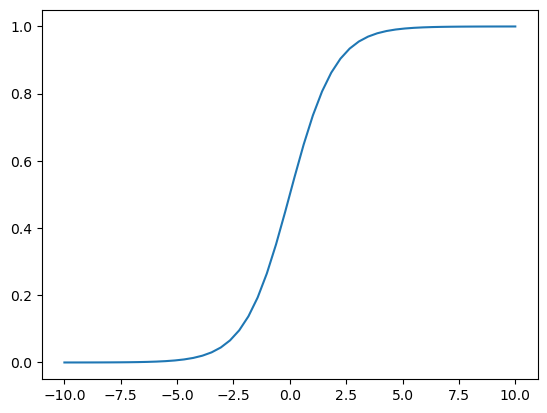

In [453]:
plt.plot(xs, ys.numpy())